In [11]:
%matplotlib inline
from __future__ import division
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from ghgforcing import CO2, CH4
import cPickle as pickle
import gzip
import os
import re

import warnings
warnings.simplefilter("once", DeprecationWarning)

/Users/Home/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


As a reminder, the emissions pickle file contains this dictionary:

```python
export_dict = {'start_emissions' : start_emissions,
               'start_list' : start_list,
               'delay_emissions' : delay_emissions,
               'delay_list' : delay_list}
```

The `start_list` and `delay_list` objects are lists with a dataframe for each of the power plant scenarios. The easiest way to calculate forcing and cumulative forcing for each of the scenarios is to loop through the lists, then concat all of the dataframes for plotting. 

## Import data

In [12]:
# load a zipped pickle file 
# from http://stackoverflow.com/questions/18474791/decreasing-the-size-of-cpickle-objects
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [13]:
import_path = os.path.join('../Data', 'emissions 1-10 percent.pgz')
import_dict = load_zipped_pickle(import_path)

In [14]:
start_list = import_dict['start_list']
start_emissions = import_dict['start_emissions']
delay_list = import_dict['delay_list']
delay_emissions = import_dict['delay_emissions']

## Calculate radiative forcing (RF) and cumulative forcing (CRF)
The function below takes a list of dataframes, calculates the RF or CRF for each set of emissions, and converts them into a single dataframe. Each RF or CRF result is copied multiple times so that it can be used with a boolean filter when plotting comparisons. For example, the RF from an SCPC with 90% capture in year 0 is compared to the equivalent NGCC power plant, but it is also compared to an NGCC without CCS. Calculating the RF/CRF once and copying the results saves time.

In [15]:
def emissions_to_forcing(df_list, kind='RF'):
    """
    Convert a list of dataframes of emissions into forcing or cumulative forcing
    
    inputs:
        df_list: list of dataframes with emissions
        kind: RF or CRF
    output:
        complete_df: single dataframe with all results    
    """
    # Define some basic parameter values
    size = 1000 # MW
    hours = 365 * 24
    capacity_factor = 0.8

    generation = size * hours * capacity_factor #MWh/yr

    end = 100
    tstep = 0.01
    time = np.linspace(0, end, num=end/tstep+1) #time array
    life = 60
    
    
    # Define column names. Use 'kind' to add RF or CRF
    first_cols = [x + kind for x in ['CO2_', 'CH4_', '']]
    df_cols = first_cols + ['Leak', 'CCS', 'Fuel', 'Methane', 'Start year', 'Time']
    
    def calculations(df):
        # Function to calculate RF or CRF for each df in the list
        out_df = pd.DataFrame(index=np.arange(0,101), columns=df_cols)
        out_df.iloc[:,0] = CO2(df['CO2'], time, kind=kind) * generation #CO2
        out_df.iloc[:,1] = CH4(df['CH4'], time, kind=kind) * generation #CH4
        out_df.iloc[:,2] = out_df.iloc[:,0] + out_df.iloc[:,1] #CO2 + CH4
        out_df[['Leak', 'CCS', 'Fuel', 'Methane','Start year']] = df.loc[0,'Leak':'Start year'].values
        out_df['Time'] = out_df.index
        
        return out_df
        
    # Use list comprehension with predefined function to speed up process
    complete_df = pd.concat(calculations(df) for df in df_list)
    complete_df.reset_index(drop=True, inplace=True)
    return complete_df

In [16]:
RF = emissions_to_forcing(start_list+delay_list)
CRF = emissions_to_forcing(start_list+delay_list, kind='CRF')

## Functions for SI figures

In [6]:
def filter_for_SI_figure(df, filter_dict):
    """
    Filter the main dataframe to include only scenarios needed for the figure.
    Also add columns needed for parameters in the seaborn FacetGrid
    
    inputs:
        df: Full dataframe of radiative forcing results
        filter_dict: A dictionary with keys of column names in the df and lists of values 
        that will be used to filter. Even single values should be included as a list.
    returns:
        filtered_df: Dataframe filtered by the dictionary with extra columns
    """
    filtered_df = df.copy()
    for key in filter_dict.keys():
        filtered_df = filtered_df.loc[filtered_df[key].isin(filter_dict[key]),:]
    
    # Sets of coal and gas ccs values
    coal_ccs = set(filtered_df.loc[filtered_df['Fuel']=='Coal','CCS'])
    gas_ccs = set(filtered_df.loc[filtered_df['Fuel']=='NG','CCS'])
    methane = set(filtered_df.loc[filtered_df['Fuel']=='NG','Methane'])
    # Need to determine the combination of results to include in the final df
    # Copy each fuel type the number of CCS scenario the other fuel has
    df_list = []
    columns = df.columns #+ ['Coal CCS', 'Gas CCS']
    for g_ccs in gas_ccs:
        for c_ccs in coal_ccs:
            for ch4 in methane:
                df = pd.DataFrame(columns=columns)
                df = filtered_df.loc[(filtered_df['Fuel']=='Coal') &
                                     (filtered_df['CCS']==c_ccs)]
                df.loc[:,'Coal CCS'] = c_ccs
                df.loc[:,'Gas CCS'] = g_ccs
                df.loc[:,'Methane'] = ch4

                df_list.append(df)
            
            df = pd.DataFrame(columns=columns)
            df = filtered_df.loc[(filtered_df['Fuel']=='NG') &
                                 (filtered_df['CCS']==g_ccs)]
            df.loc[:,'Coal CCS'] = c_ccs
            df.loc[:,'Gas CCS'] = g_ccs
            
            df_list.append(df)
    
    final_df = pd.concat(df_list)
    
    return final_df

In [13]:
def plot_SI_results(df, filter_dict, row, col, hue='Leak', plot_style='whitegrid', 
            palette=[sns.xkcd_rgb['bright blue']] + sns.cubehelix_palette(10, 0.2, hue=1),
            leaks=['SCPC', 'NGCC 1%', 'NGCC 2%', 'NGCC 3%', 'NGCC 4%', 'NGCC 5%',
                   'NGCC 6%', 'NGCC 7%', 'NGCC 8%', 'NGCC 9%', 'NGCC 10%'], 
            kind='RF'):
    """
    Filter the dataframe and plot desired scenarios in a seaborn FacetGrid
    
    inputs:
        df: dataframe of forcing or culmulative forcing
        filter_dict: dictionary with keys corresponding to column names in the df,
        and list values
        row: variable to split subplots across rows
        col: variable to split subplots across columns
        hue: (default "Leak") variable to split by color within a facet
        plot_style: seaborn axes style
        palette: color palette for hue
        leaks: list of ordered leak values
        kind: RF or CRF, changes the y-axis label
    """
    
    df = filter_for_SI_figure(df, filter_dict)    
    
    with sns.axes_style('whitegrid'):
        g = sns.FacetGrid(df, col=col, row=row, hue=hue, palette=palette, aspect=1.3,
                          hue_order=leaks,
                    )
        g.map(plt.plot, 'Time', kind)
        
#         handles, labels = g.ax.get_legend_handles_labels()
#         g.add_legend(handles[::-1], labels[::-1])
        g.add_legend(title='')
        
    
        if kind == 'RF':
            label = 'Forcing ($W \ m^{-2}$)'
        elif kind == 'CRF':
            label = 'Cumulative Forcing ($W \ m^{-2} \ y$)'

#         g.fig.suptitle(title,y=1.02, size=15)
        
        # Only trying to change things in the first column of axes objects
        for ax in [axs[0] for axs in g.axes]:
            ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.1e'))
            ax.set_ylabel(label)

## Plot RF results

/Users/Home/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Home/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


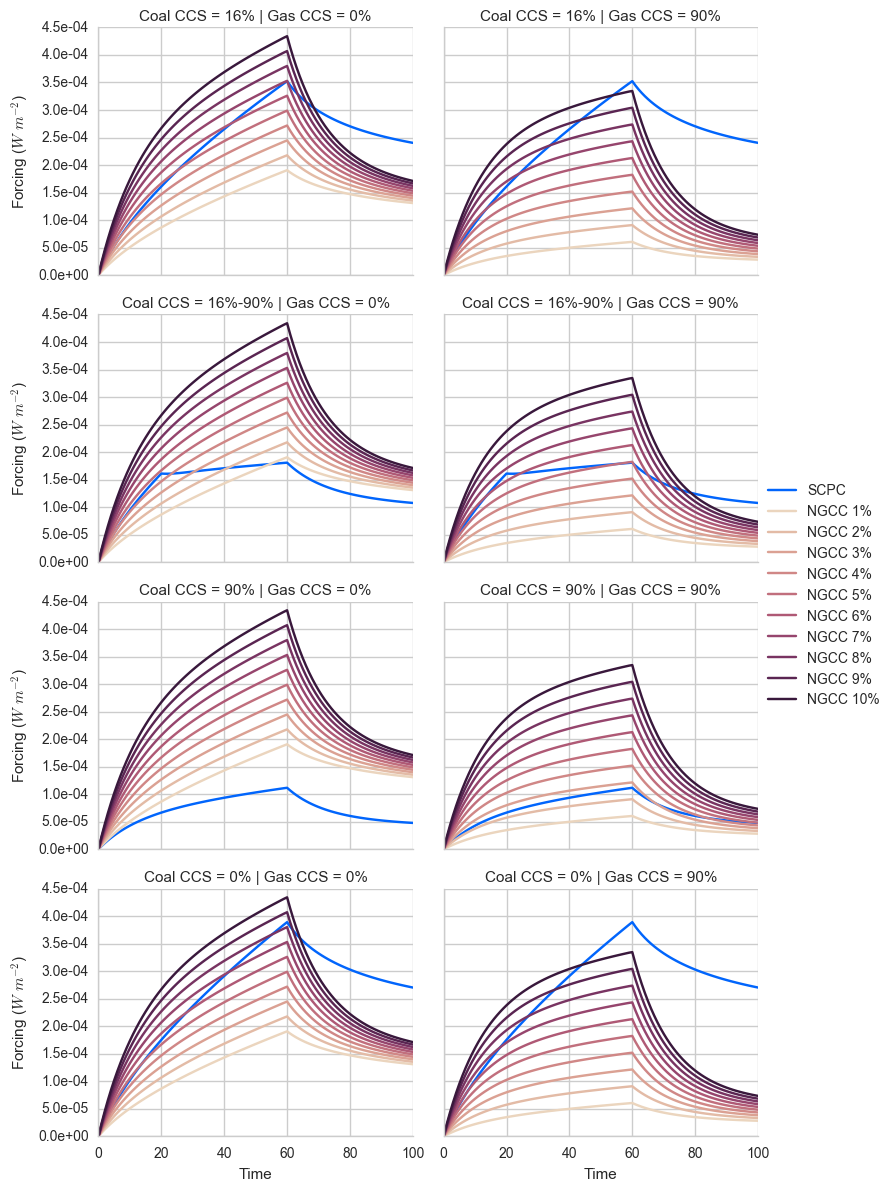

In [8]:
filter_dict = {'Methane' : ['Constant', None],
               'Start year' : [0]}
plot_SI_results(RF, filter_dict, row='Coal CCS', col='Gas CCS')
file_path = os.path.join('../Figures', 'RF Constant methane CCS year 0.pdf')
plt.savefig(file_path)

/Users/Home/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Home/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


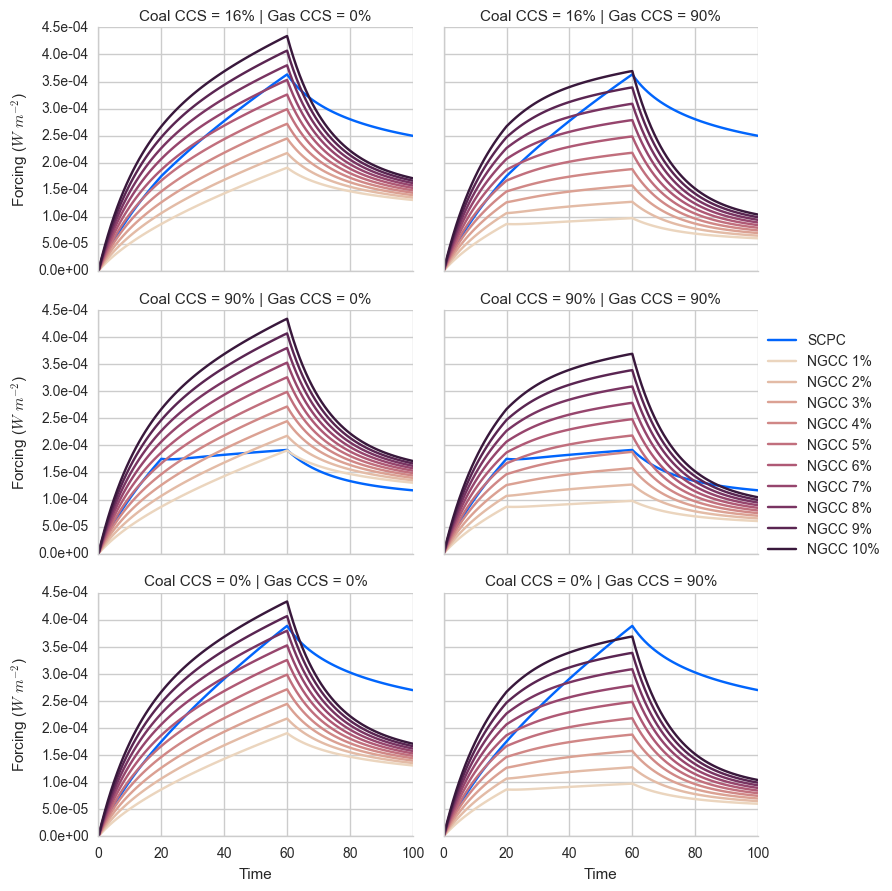

In [8]:
filter_dict = {'Methane' : ['Constant', None],
               'Start year' : [20]}
plot_SI_results(RF, filter_dict, row='Coal CCS', col='Gas CCS')
file_path = os.path.join('../Figures', 'RF Constant methane CCS year 20.pdf')
plt.savefig(file_path)

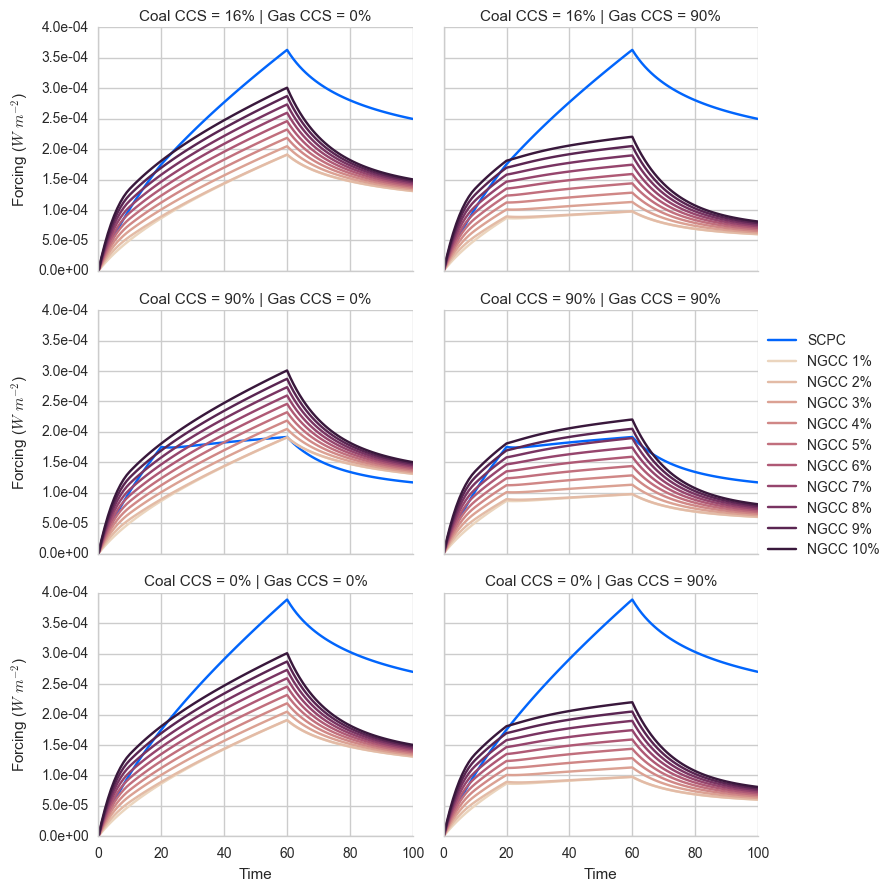

In [9]:
filter_dict = {'Methane' : ['Reduce', None],
               'Start year' : [20]}
plot_SI_results(RF, filter_dict, row='Coal CCS', col='Gas CCS')
file_path = os.path.join('../Figures', 'RF Reduce methane CCS year 20.pdf')
plt.savefig(file_path)

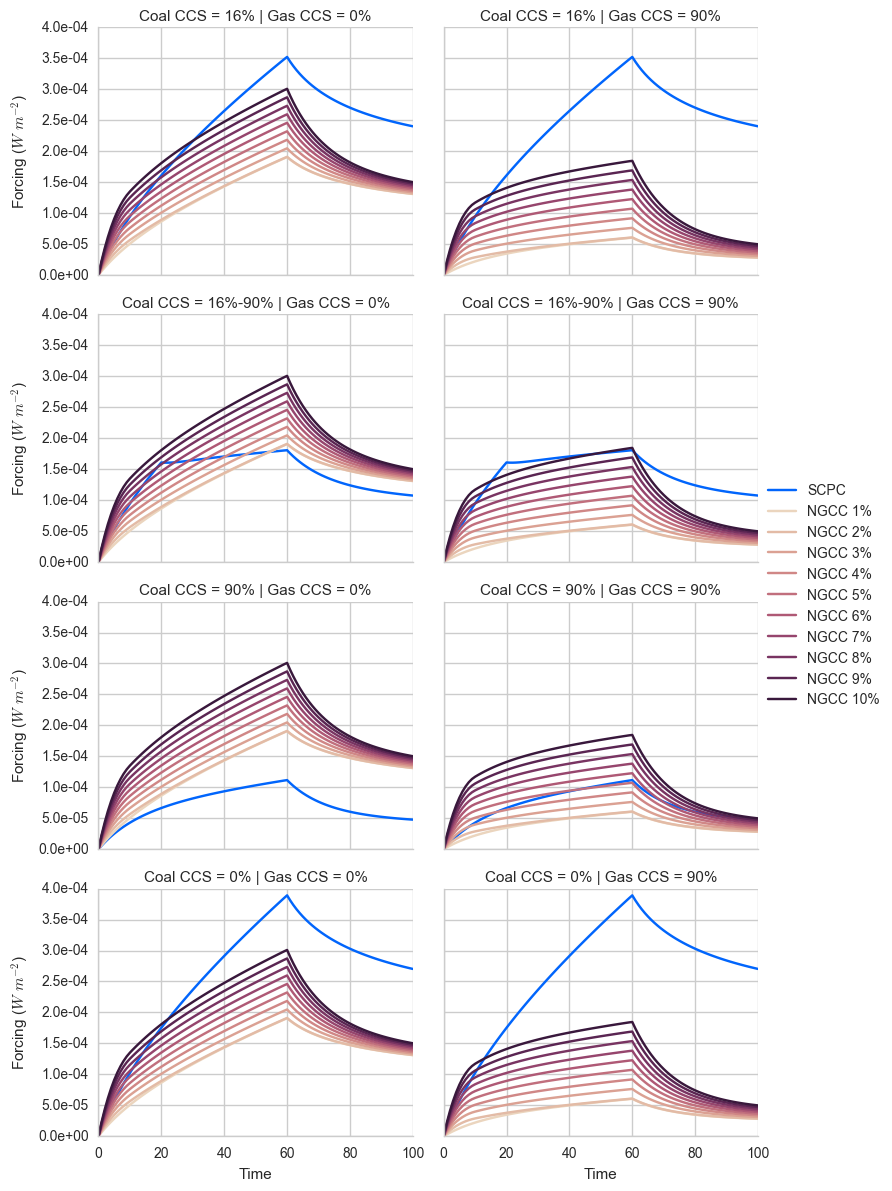

In [10]:
filter_dict = {'Methane' : ['Reduce', None],
               'Start year' : [0]}
plot_SI_results(RF, filter_dict, row='Coal CCS', col='Gas CCS')
file_path = os.path.join('../Figures', 'RF Reduce methane CCS year 0.pdf')
plt.savefig(file_path)

## Plot CRF results

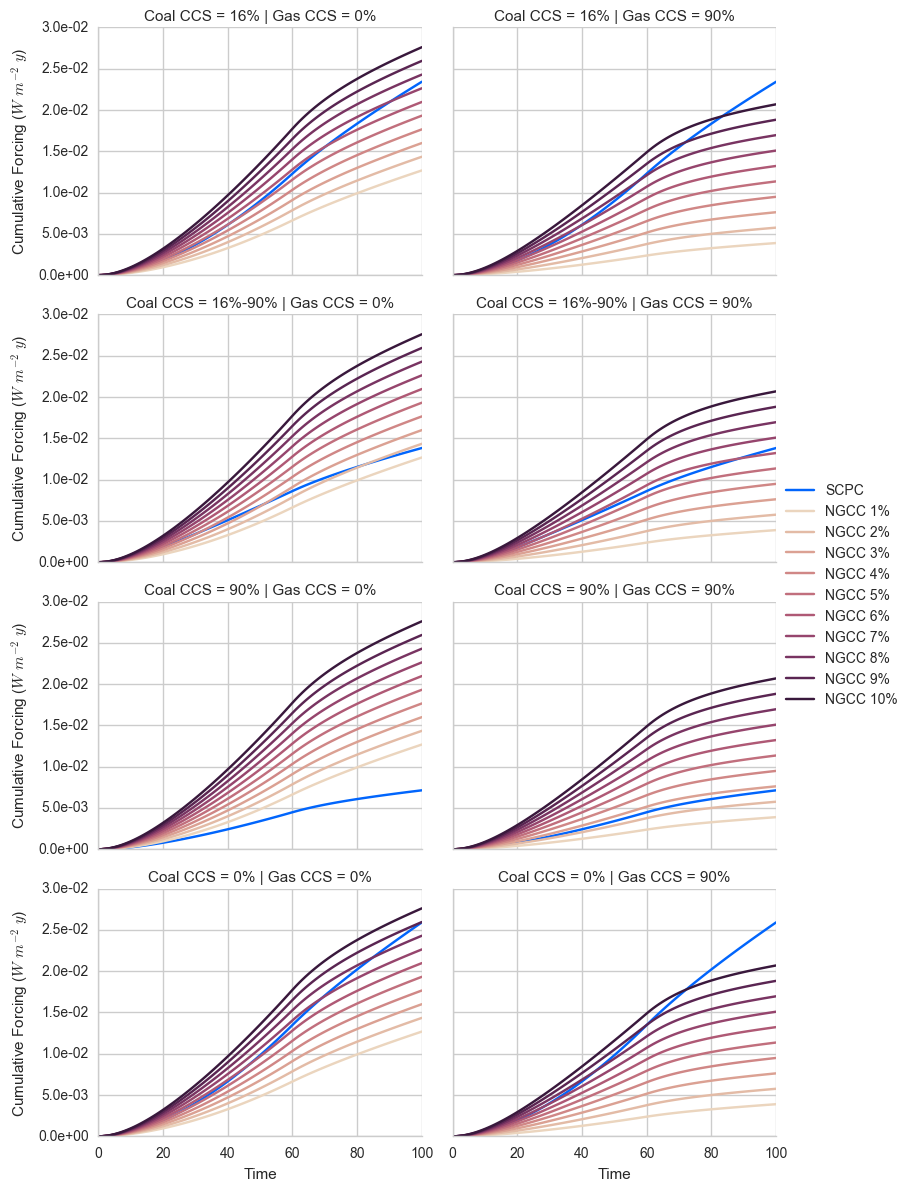

In [14]:
filter_dict = {'Methane' : ['Constant', None],
               'Start year' : [0]}
plot_SI_results(CRF, filter_dict, row='Coal CCS', col='Gas CCS', kind='CRF')
file_path = os.path.join('../Figures', 'CRF Constant methane CCS year 0.pdf')
plt.savefig(file_path)

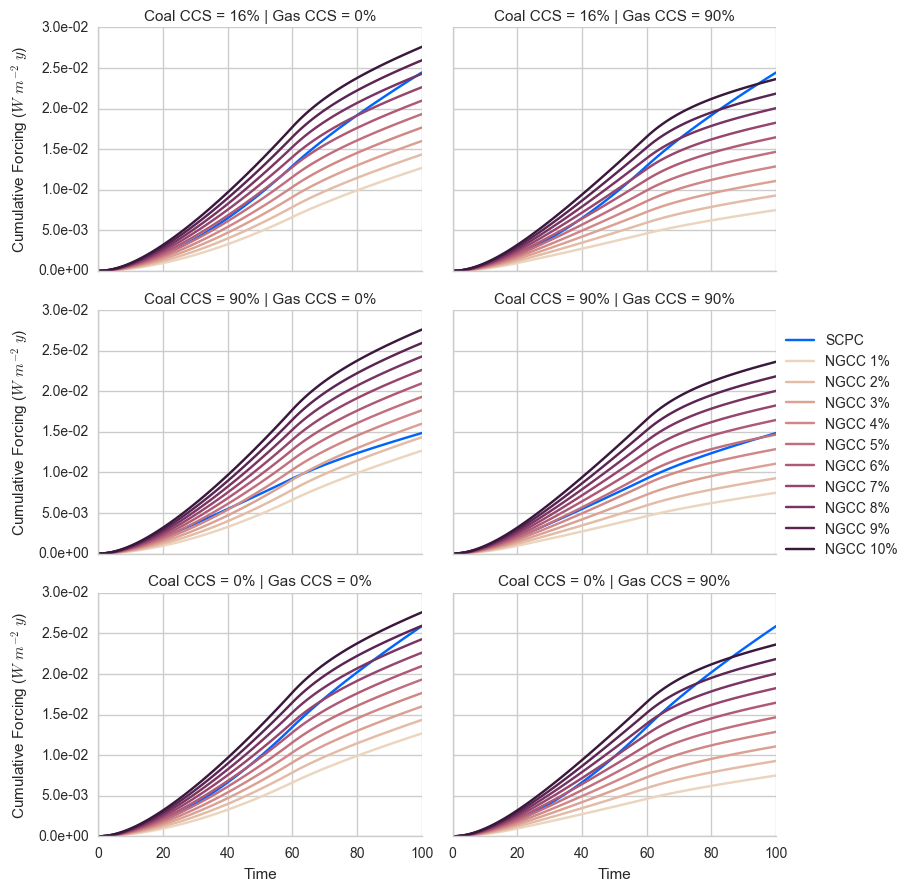

In [15]:
filter_dict = {'Methane' : ['Constant', None],
               'Start year' : [20]}
plot_SI_results(CRF, filter_dict, row='Coal CCS', col='Gas CCS', kind='CRF')
file_path = os.path.join('../Figures', 'CRF Constant methane CCS year 20.pdf')
plt.savefig(file_path)

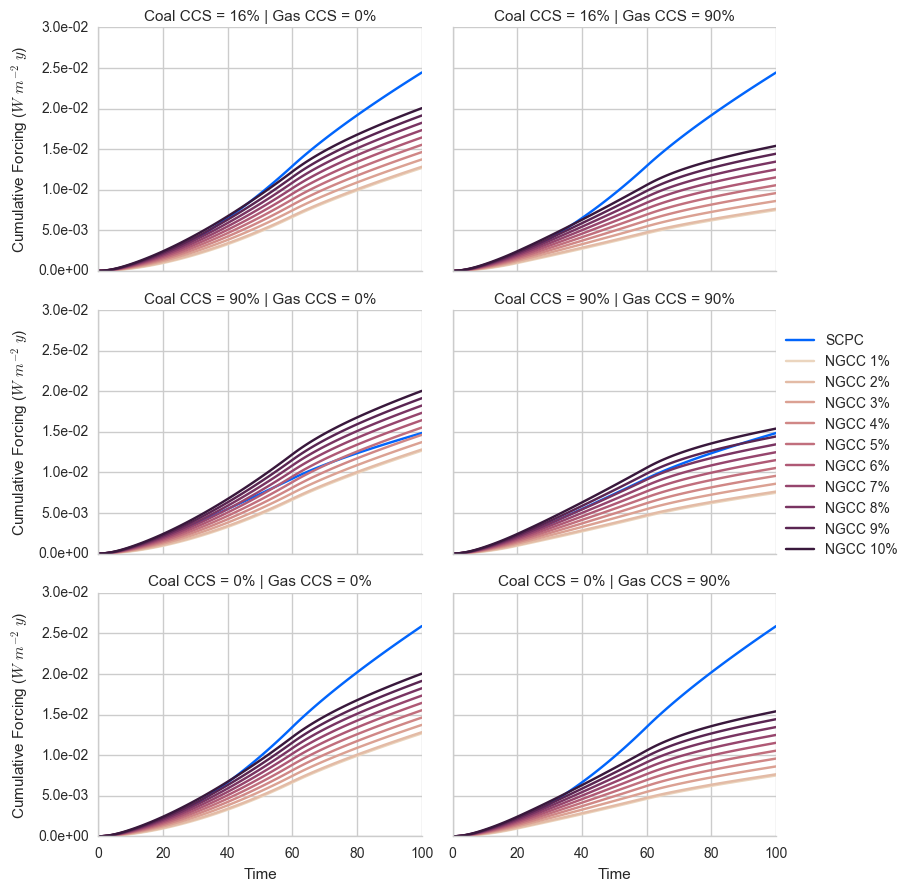

In [17]:
filter_dict = {'Methane' : ['Reduce', None],
               'Start year' : [20]}
plot_SI_results(CRF, filter_dict, row='Coal CCS', col='Gas CCS', kind='CRF')
file_path = os.path.join('../Figures', 'CRF Reduce methane CCS year 20.pdf')
plt.savefig(file_path)

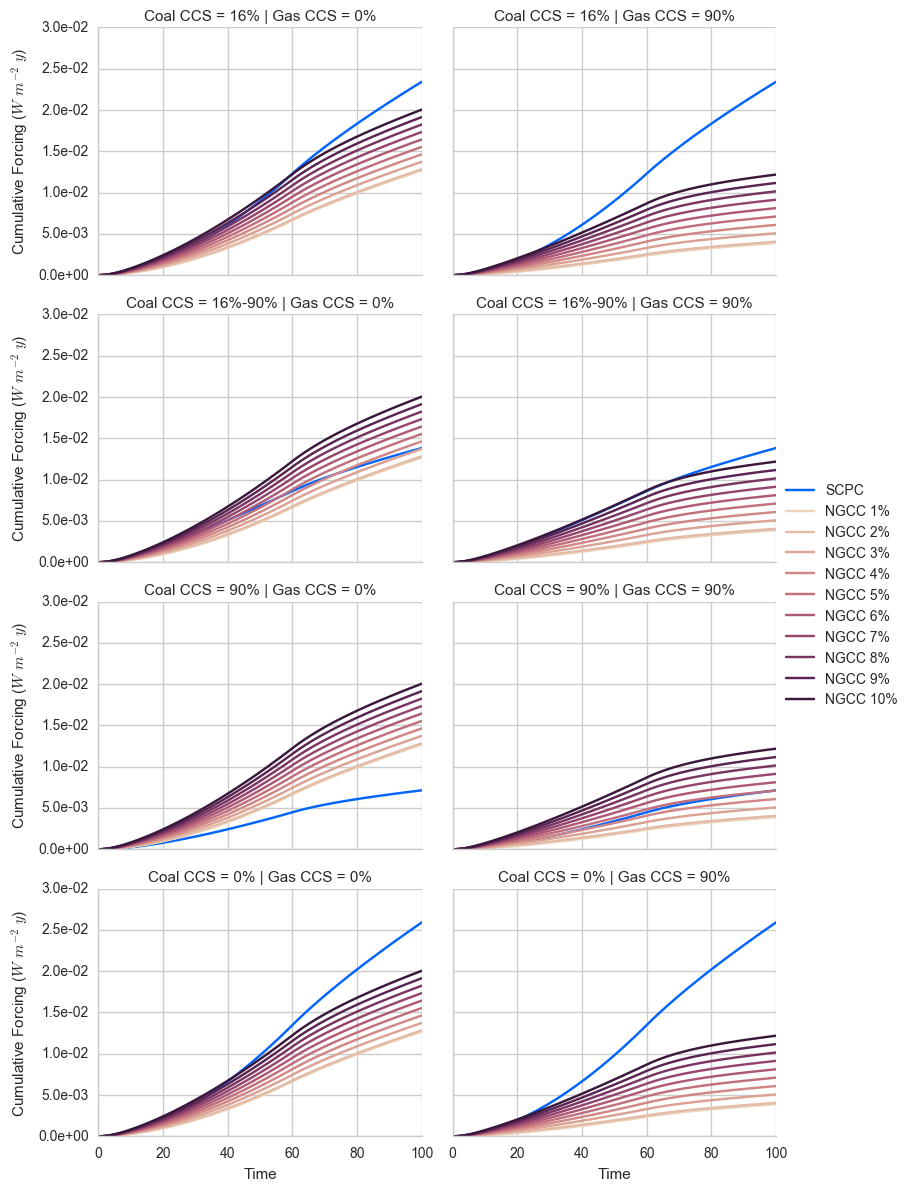

In [18]:
filter_dict = {'Methane' : ['Reduce', None],
               'Start year' : [0]}
plot_SI_results(CRF, filter_dict, row='Coal CCS', col='Gas CCS', kind='CRF')
file_path = os.path.join('../Figures', 'CRF Reduce methane CCS year 0.pdf')
plt.savefig(file_path)

## Calculate difference in RF and CRF

Define scenarios for the main RF/CRF figures in a dictionary. Additional scenarios for CCS start year of 0 and 20 are not included here - they will be used in the figure generation function.

In [5]:
fig_scenarios = {'a' : {'Coal CCS' : '90%',
                        'Gas CCS' : '90%',
                        'Methane' : 'Constant'},
                 'b' : {'Coal CCS' : '90%',
                        'Gas CCS' : '0%',
                        'Methane' : 'Constant'},
                 'c' : {'Coal CCS' : '16%',
                        'Gas CCS' : '90%',
                        'Methane' : 'Constant'},
                 'd' : {'Coal CCS' : '16%',
                        'Gas CCS' : '0%',
                        'Methane' : 'Constant'},
                 'e' : {'Coal CCS' : '90%',
                        'Gas CCS' : '90%',
                        'Methane' : 'Reduce'},
                 'f' : {'Coal CCS' : '90%',
                        'Gas CCS' : '0%',
                        'Methane' : 'Reduce'},
                 'g' : {'Coal CCS' : '16%',
                        'Gas CCS' : '90%',
                        'Methane' : 'Reduce'},
                 'h' : {'Coal CCS' : '16%',
                        'Gas CCS' : '0%',
                        'Methane' : 'Reduce'}}

In [98]:
class Main_figure:
    def __init__(self):
        pass
    
    def figure_data(self, df, scenarios, leak_rates=range(1,6), kind='RF'):
    
        leak_values = ['NGCC ' + str(x) + '%' for x in leak_rates]
        self.data_dfs = {}
        self.scenarios=scenarios
        for key in self.scenarios.keys():
            self.data_dfs[key] = {}
            # Assuming that start years are only 0 and 20
            for start in [0, 20]:
                temp_df_coal = df.loc[(df['CCS']==self.scenarios[key]['Coal CCS']) &
                                 (df['Fuel']=='Coal') &
                                 (df['Start year']==start)]
                temp_df_gas = df.loc[(df['CCS']==self.scenarios[key]['Gas CCS']) &
                                 (df['Fuel']=='NG') &
                                 (df['Methane']==self.scenarios[key]['Methane']) &
                                 (df['Start year']==start)]
                temp_df = pd.concat([temp_df_coal, temp_df_gas])

                # Populate a temporary list of dfs that get concatenated
                temp_list = []
                for leak in leak_values:
                    diff = pd.DataFrame(columns=['Difference', 'Leak', 'Time'])
                    diff.loc[:,'Difference'] = (temp_df.loc[temp_df['Fuel']=='Coal', kind].values - 
                        temp_df.loc[(temp_df['Fuel']=='NG')&(temp_df['Leak']==leak), kind].values)
                    diff.loc[:,'Leak'] = leak
                    diff.loc[:,'Time'] = temp_df.loc[temp_df['Fuel']=='Coal', 'Time'].values

                    temp_list.append(diff)

                self.data_dfs[key][start] = pd.concat(temp_list)

#         return data_dfs
    
    def find_max_abs(self, data, leak_rates=range(1,6), data_column='Difference'):
        """"
        Returns the maximum absolute value from the dataframe. 
        Used to scale the colorbar.

        -----
        data: dataframe input
        leak_rates: string or list of values that are expected in the 'leak' column of
                    the dataframe
        data_column: string or list of dataframe column to find the abs max of
        """
        leak_values = ['NGCC ' + str(x) + '%' for x in leak_rates]
        
        
        filtered_data = data.loc[data['Leak'].isin(leak_values), data_column].copy()

        max_value = filtered_data.values.max()
        min_value = filtered_data.values.min()
        self.abs_max = max(max_value, abs(min_value))

        return self.abs_max
    
    def set_color_values(self):
        self.df_list = []
        for key1 in self.data_dfs.keys():
            for key2 in self.data_dfs[key1].keys():
                self.df_list.append(self.data_dfs[key1][key2])

        cbar_scale = self.find_max_abs(pd.concat(self.df_list))

        self.c = plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-cbar_scale, vmax=cbar_scale), cmap='RdBu')
        c_lambda = lambda x: self.c.to_rgba(x)
        for key1 in self.data_dfs.keys():
            for key2 in self.data_dfs[key1].keys():
                self.data_dfs[key1][key2].loc[:,'Color'] = self.data_dfs[key1][key2].loc[:,'Difference'].apply(c_lambda)
#         return self.data_dfs, self.c
    
    def plot_heatmap(self, leak_rates=range(1,6), delay_years=[0,20]):
        sns.set_style('white')
        leak_values = ['NGCC ' + str(x) + '%' for x in leak_rates]

        fig, axs = plt.subplots(2, 4, figsize=(13,6), sharey=True, sharex=True)

        # Set the bar width
        bar_width = 0.25 * 3.0/5.0 # multiply by 3/5 when including all 5 leak rates

        # positions of the left bar-boundaries
        bar_l = [i+1 for i in range(3)] 

        # positions of the x-axis ticks (center of the bars as bar labels)
        start_ticks = [1 + bar_width * i + (bar_width/2.0) for i in range(5)]
        delay_ticks = [2 + bar_width * i + (bar_width/2.0) for i in range(5)]

        xticks = start_ticks + delay_ticks

        # list of tick labels
        xticklabels = ['1% start', '', '3% start', '', '5% start','1% delay', '',
                              '3% delay', '', '5% delay']

        scenario_keys = self.scenarios.keys()
        scenario_keys.sort()
        for key, ax in zip(scenario_keys, axs.flat):
            title = self.scenarios[key]['Coal CCS']  + ' SCPC, ' + \
                    self.scenarios[key]['Gas CCS']  + ' NGCC CCS'

            for idx, leak in enumerate(leak_values):
                for i in range(100):
                    # Manually using the passed list of delay_years, assuming only 2 values
                    temp_df = self.data_dfs[key][delay_years[0]]
                    temp_df = temp_df.loc[temp_df['Leak']==leak,:]

                    ax.bar(left = 1 + idx * bar_width,
                           height = i+1,
                           width = bar_width,
                           bottom = i,
                           color=temp_df.loc[i,'Color'],
                           linewidth=0)

                    temp_df = self.data_dfs[key][delay_years[1]]
                    temp_df = temp_df.loc[temp_df['Leak']==leak,:]

                    ax.bar(left = 2 + idx * bar_width,
                           height = i+1,
                           width = bar_width,
                           bottom = i,
                           color=temp_df.loc[i,'Color'],
                           linewidth=0)

                ax.set_title(title)
                ax.text(0.47, 0.5, key, transform = ax.transAxes, size = 15) #subplot labeling
                ax.set_xticks([a for a in xticks])
                ax.set_xticklabels((a[0:2] for a in xticklabels))
                ax.tick_params(axis='both', which='major', length=4, width=1)

                # Add "start" and "delay" labels to the 4 bottom subplots
                if key in 'efgh':
                    ax.text(0.21, -0.15, 'Start', horizontalalignment='center',
                            verticalalignment='center', transform=ax.transAxes, size = 12)
                    ax.text(0.79, -0.15, 'Delay', horizontalalignment='center',
                            verticalalignment='center', transform=ax.transAxes, size = 12)

                # y-axis labels on the leftmost subplots
                if key == 'a':
                    ax.set_ylabel('Years after start\n(Constant leakage)')

                if key == 'e':
                    ax.set_ylabel('Years after start\n(Reduce leakage)')

        plt.ylim(0,100)

        # Text objects are being plotted on the last axis (bottom right)
        # so they need to be well outside the actual plot. The coordinates are using
        # the transformed axis (I think?).

        plt.annotate('SCPC Higher', xy=(1.43, 2.1), xycoords = ax.transAxes,
                     xytext = (1.43, 1.75), textcoords=ax.transAxes, ha='center',
                     arrowprops=dict(facecolor='black', width = 1, headwidth=6), rotation=270)

        plt.annotate('SCPC Lower', xy=(1.43, 0.1), xycoords = ax.transAxes,
                     xytext = (1.43, 0.7), textcoords=ax.transAxes, ha='center',
                     arrowprops=dict(facecolor='black', width = 1, headwidth=6), rotation=270)

        plt.tight_layout()

        self.c._A = [] # I have no clue why I need to do this
        cbar = fig.colorbar(self.c, ax=axs.ravel().tolist())
        cbar.ax.set_title('$W \ m^{-2}$', size = 13)



        cticks = [2.4e-4, 1.2e-4, 0, -1.2e-4, -2.4e-4]

        # Make the labels absolute value, but still with scientific notation
        cticklables = ['{0:.1e}'.format(abs(i)) for i in cticks]

        cbar.set_ticks(cticks)
        cbar.set_ticklabels(cticklables)
        cbar.ax.yaxis.set_ticks_position('right')

        sns.despine()

In [99]:
RF_fig = Main_figure()

In [100]:
RF_fig.figure_data(RF, fig_scenarios)

In [101]:
RF_fig.set_color_values()

In [104]:
%pdb

Automatic pdb calling has been turned ON


['a', 'c', 'b', 'e', 'd', 'g', 'f', 'h']


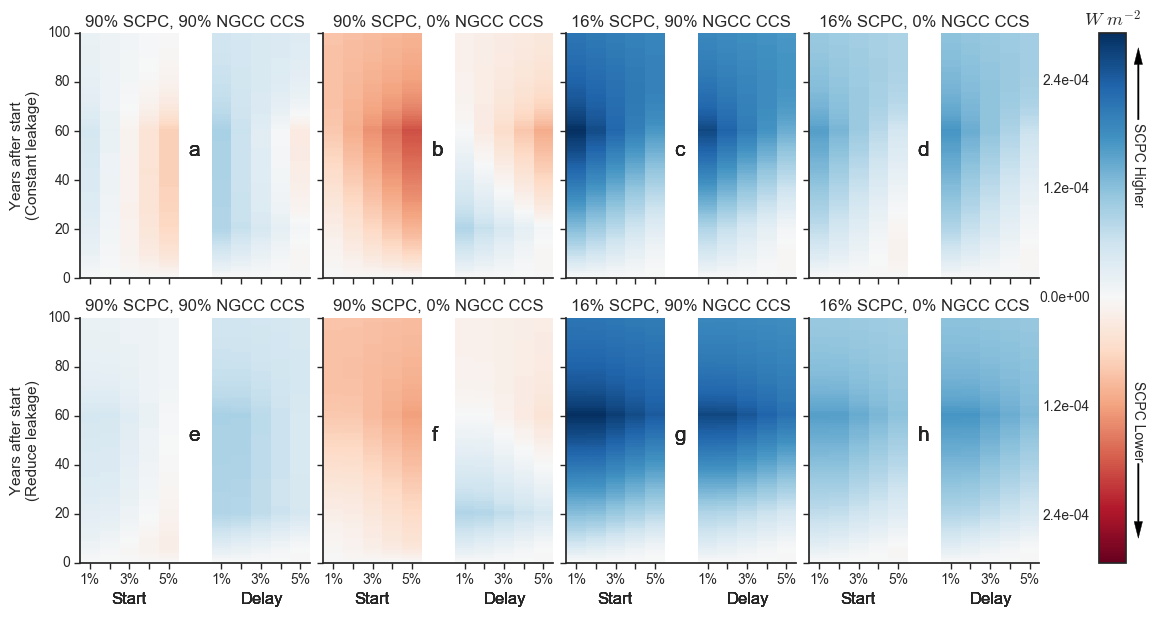

In [106]:
RF_fig.plot_heatmap()

In [107]:
def figure_data(df, params, leak_rates=range(1,6), kind='RF'):
    
    leak_values = ['NGCC ' + str(x) + '%' for x in leak_rates]
    data_dfs = {}
    for key in params.keys():
        data_dfs[key] = {}
        # Assuming that start years are only 0 and 20
        for start in [0, 20]:
            temp_df_coal = df.loc[(df['CCS']==params[key]['Coal CCS']) &
                             (df['Fuel']=='Coal') &
                             (df['Start year']==start)]
            temp_df_gas = df.loc[(df['CCS']==params[key]['Gas CCS']) &
                             (df['Fuel']=='NG') &
                             (df['Methane']==params[key]['Methane']) &
                             (df['Start year']==start)]
            temp_df = pd.concat([temp_df_coal, temp_df_gas])
            
            # Populate a temporary list of dfs that get concatenated
            temp_list = []
            for leak in leak_values:
                diff = pd.DataFrame(columns=['Difference', 'Leak', 'Time'])
                diff.loc[:,'Difference'] = (temp_df.loc[temp_df['Fuel']=='Coal', kind].values - 
                    temp_df.loc[(temp_df['Fuel']=='NG')&(temp_df['Leak']==leak), kind].values)
                diff.loc[:,'Leak'] = leak
                diff.loc[:,'Time'] = temp_df.loc[temp_df['Fuel']=='Coal', 'Time'].values
                                      
                temp_list.append(diff)
            data_dfs[key][start] = pd.concat(temp_list)
    return data_dfs

In [108]:
test = figure_data(RF, fig_scenarios)

In [112]:
def set_color_values(data_dfs):
    df_list = []
    for key1 in data_dfs.keys():
        for key2 in data_dfs[key1].keys():
            df_list.append(data_dfs[key1][key2])
    
    cbar_scale = find_max_abs(pd.concat(df_list))
    
    c = plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=-cbar_scale, vmax=cbar_scale), cmap='RdBu')
    c_lambda = lambda x: c.to_rgba(x)
    for key1 in data_dfs.keys():
        for key2 in data_dfs[key1].keys():
            data_dfs[key1][key2].loc[:,'Color'] = data_dfs[key1][key2].loc[:,'Difference'].apply(c_lambda)
    return data_dfs, c

In [113]:
data_dfs, c = set_color_values(test)

In [128]:
def heatmap_fig(data_dfs, c, scenarios=fig_scenarios, leak_rates=range(1,6),
               delay_years=[0,20]):
    sns.set_style('white')
    leak_values = ['NGCC ' + str(x) + '%' for x in leak_rates]
    
    fig, axs = plt.subplots(2, 4, figsize=(13,6), sharey=True, sharex=True)
    
    # Set the bar width
    bar_width = 0.25 * 3.0/5.0 # multiply by 3/5 when including all 5 leak rates
    
    # positions of the left bar-boundaries
    bar_l = [i+1 for i in range(3)] 

    # positions of the x-axis ticks (center of the bars as bar labels)
    start_ticks = [1 + bar_width * i + (bar_width/2.0) for i in range(5)]
    delay_ticks = [2 + bar_width * i + (bar_width/2.0) for i in range(5)]

    xticks = start_ticks + delay_ticks

    # list of tick labels
    xticklabels = ['1% start', '', '3% start', '', '5% start','1% delay', '',
                          '3% delay', '', '5% delay']
    
    scenario_keys = fig_scenarios.keys()
    scenario_keys.sort()
    for key, ax in zip(scenario_keys, axs.flat):
        title = scenarios[key]['Coal CCS']  + ' SCPC, ' + \
                scenarios[key]['Gas CCS']  + ' NGCC CCS'
            
        for idx, leak in enumerate(leak_values):
            for i in range(100):
                # Manually using the passed list of delay_years, assuming only 2 values
                temp_df = data_dfs[key][delay_years[0]]
                temp_df = temp_df.loc[temp_df['Leak']==leak,:]
                
                ax.bar(left = 1 + idx * bar_width,
                       height = i+1,
                       width = bar_width,
                       bottom = i,
                       color=temp_df.loc[i,'Color'],
                       linewidth=0)
                
                temp_df = data_dfs[key][delay_years[1]]
                temp_df = temp_df.loc[temp_df['Leak']==leak,:]
                
                ax.bar(left = 2 + idx * bar_width,
                       height = i+1,
                       width = bar_width,
                       bottom = i,
                       color=temp_df.loc[i,'Color'],
                       linewidth=0)
                
            ax.set_title(title)
            ax.text(0.47, 0.5, key, transform = ax.transAxes, size = 15) #subplot labeling
            ax.set_xticks([a for a in xticks])
            ax.set_xticklabels((a[0:2] for a in xticklabels))
            ax.tick_params(axis='both', which='major', length=4, width=1)

            # Add "start" and "delay" labels to the 4 bottom subplots
            if key in 'efgh':
                ax.text(0.21, -0.15, 'Start', horizontalalignment='center',
                        verticalalignment='center', transform=ax.transAxes, size = 12)
                ax.text(0.79, -0.15, 'Delay', horizontalalignment='center',
                        verticalalignment='center', transform=ax.transAxes, size = 12)

            # y-axis labels on the leftmost subplots
            if key == 'a':
                ax.set_ylabel('Years after start\n(Constant leakage)')

            if key == 'e':
                ax.set_ylabel('Years after start\n(Reduce leakage)')
    
    plt.ylim(0,100)

    # Text objects are being plotted on the last axis (bottom right)
    # so they need to be well outside the actual plot. The coordinates are using
    # the transformed axis (I think?).

    plt.annotate('SCPC Higher', xy=(1.43, 2.1), xycoords = ax.transAxes,
                 xytext = (1.43, 1.75), textcoords=ax.transAxes, ha='center',
                 arrowprops=dict(facecolor='black', width = 1, headwidth=6), rotation=270)

    plt.annotate('SCPC Lower', xy=(1.43, 0.1), xycoords = ax.transAxes,
                 xytext = (1.43, 0.7), textcoords=ax.transAxes, ha='center',
                 arrowprops=dict(facecolor='black', width = 1, headwidth=6), rotation=270)

    plt.tight_layout()

    c._A = [] # I have no clue why I need to do this
    cbar = fig.colorbar(c, ax=axs.ravel().tolist())
    cbar.ax.set_title('$W \ m^{-2}$', size = 13)



    cticks = [2.4e-4, 1.2e-4, 0, -1.2e-4, -2.4e-4]

    # Make the labels absolute value, but still with scientific notation
    cticklables = ['{0:.1e}'.format(abs(i)) for i in cticks]

    cbar.set_ticks(cticks)
    cbar.set_ticklabels(cticklables)
    cbar.ax.yaxis.set_ticks_position('right')

    sns.despine()

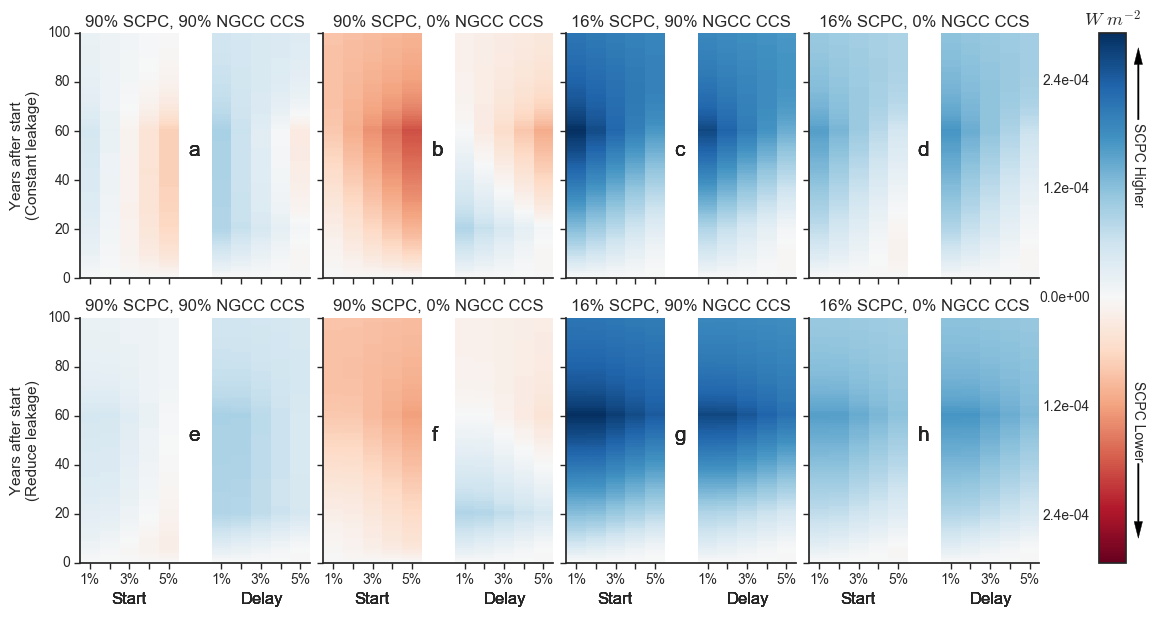

In [129]:
heatmap_fig(data_dfs, c)